# KNSB ProPEP Automation

## Setting up the environment

I'll be using a powerful tool known as [Cantera](https://cantera.org/3.1/userguide/python-tutorial.html) for this task. It calculates everything accurately and efficiently. Also ensure you've set up Jupyter on your machine. First, I'll install the libraries:

In [1]:
# This script updates or installs the necessary Python packages
%pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Now the fun part...

I'll first start by importing the various libraries we need for this task. 


In [2]:
import numpy as np
import pandas as pd
import cantera as ct
import matplotlib.pyplot as plt

Then I'll define my global variables that will be used throughout the code. For this we'll need the **mechanism** which points to a yaml file that contains the details of the Grains in question and to define some lists like the **flame temp.** and **specific impulse** that will contain the calculated values from our script

We'll then parse the data in the CSV file and get the masses of $KNO_3$ and $C_6H_{14}O_6$ and store them as a dataframe.

In [3]:
df = pd.read_csv("../csv/base_propep_simulations.csv")
df.head()

,KNO3 (%),Sorbitol (%),Mass KNO3 (g),Mass Sorbitol (g),C*,Density,Chamber Cp/Cv,Chamber Temp,Isp*,Molecular Weight
0,70.00,30.00,1017.52,592.10,NaN,NaN,NaN,NaN,NaN,NaN
1,69.75,30.25,1013.89,597.03,NaN,NaN,NaN,NaN,NaN,NaN
2,69.50,30.50,1010.25,601.97,NaN,NaN,NaN,NaN,NaN,NaN
3,69.25,30.75,1006.62,606.90,NaN,NaN,NaN,NaN,NaN,NaN
4,69.00,31.00,1002.98,611.83,NaN,NaN,NaN,NaN,NaN,NaN


We'll then define our variables that will be used in the whole script:

In [ ]:
mechanism = ct.Solution("../yaml/knsb_base.yaml")

mix = ct.Solution("../yaml/knsb_base.yaml", "KNSB-combusting")

We'll start by calculating the propellant desnities, $\rho_p$ and adding them to the csv file. We'll be using the following formula:

$$
\rho_p = \frac{1}{\frac{f_0}{\rho_0}+\frac{f_1}{\rho_1}}
$$

where $f_n$ is the **mass fraction** of the propellant component and $\rho_n$ is the respective density.

In [9]:
density_kno3 = 2.109
density_sorb = 1.489
densities = []

for _, row in df.iterrows():
    mass_sorb = row["Mass Sorbitol (g)"]
    mass_kno3 = row["Mass KNO3 (g)"]

    f_kno3 = row["KNO3 (%)"] / 100
    f_sorb = row["Sorbitol (%)"] / 100
    
    ratio_kno3 = f_kno3 / density_kno3
    ratio_sorb = f_sorb / density_sorb
    
    density_knsb = (1 / (ratio_kno3 + ratio_sorb)) / 27.68
    densities.append(density_knsb)

df['Density'] = densities
df.head()

,KNO3 (%),Sorbitol (%),Mass KNO3 (g),Mass Sorbitol (g),C*,Density,Chamber Cp/Cv,Chamber Temp,Isp*,Molecular Weight
0,70.00,30.00,1017.52,592.10,NaN,0.067731,NaN,NaN,NaN,NaN
1,69.75,30.25,1013.89,597.03,NaN,0.067669,NaN,NaN,NaN,NaN
2,69.50,30.50,1010.25,601.97,NaN,0.067606,NaN,NaN,NaN,NaN
3,69.25,30.75,1006.62,606.90,NaN,0.067544,NaN,NaN,NaN,NaN
4,69.00,31.00,1002.98,611.83,NaN,0.067482,NaN,NaN,NaN,NaN


Now that's sorted, we can calculate the following data as per the csv file:
- **Chamber velocity** ($C^*$): This is essential in determining the speed at which the propellant will burn at
- **Chamber $c_p/c_v$** ($\gamma$): this is the **specific heat ratio** and it is used to determine the chamber pressure
- **Specific impulse** ($I_{sp}$): this is the crucial factor that determines the thrust of our SRM

In [ ]:
chamber_pressure = 4.26e+06

chamber_temps = []
cp_cv_ratios = []
mol_weights = []
c_stars = []
isps = []

for index, row in df.iterrows():
    mass_kno3 = row['Mass KNO3 (g)']
    mass_sorbitol = row['Mass Sorbitol (g)']

    mw_kno3 = 101.1032
    mw_sorbitol = 182.172

    moles_kno3 = mass_kno3 / mw_kno3
    moles_sorbitol = mass_sorbitol / mw_sorbitol

    mix.set_equivalence_ratio(phi=1.0, fuel='C3H7O3:0.65', oxidizer='KNO3:0.35', basis='mass')
    mix.TP = 300, chamber_pressure
    mix.equilibrate('HP')
    
    T_chamber = mix.T
    gamma = mix.cp / mix.cv
    mw = mix.mean_molecular_weight
    
    R = ct.gas_constant / mw
    c_star_val = np.sqrt(gamma * R * T_chamber) / gamma

    exit_pressure = 1.01325e+06
    isp_val = (np.sqrt(2 * gamma / (gamma - 1) * R * T_chamber * 
               (1 - (exit_pressure / chamber_pressure)**((gamma - 1) / gamma)))) / 9.81
    
    chamber_temps.append(T_chamber)
    cp_cv_ratios.append(gamma)
    mol_weights.append(mw)
    c_stars.append(c_star_val)
    isps.append(isp_val)

df['Chamber Temp'] = chamber_temps
df['Chamber Cp/Cv'] = cp_cv_ratios
df['Molecular Weight'] = mol_weights
df['C*'] = c_stars
df['Isp*'] = isps

df.head()

CanteraError: 
*******************************************************************************
CanteraError thrown by Phase::getCompositionFromMap:
Unknown species 'C3H7O3'
*******************************************************************************


From this data we can show the relationship between $I_{sp}$ and mass of $KNO_3$ used:

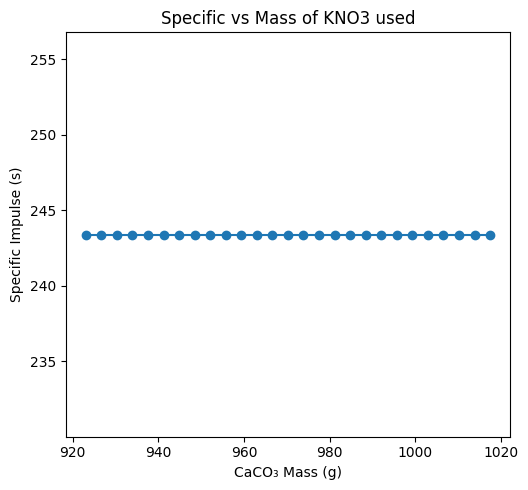

In [15]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(df.iloc[:, 2], isps, marker='o')
plt.xlabel('CaCO₃ Mass (g)')
plt.ylabel('Specific Impulse (s)')
plt.title('Specific vs Mass of KNO3 used')

plt.tight_layout()
plt.show()

We can also outline the relationship between the flame temperatures and mass of $KNO_3$ used:

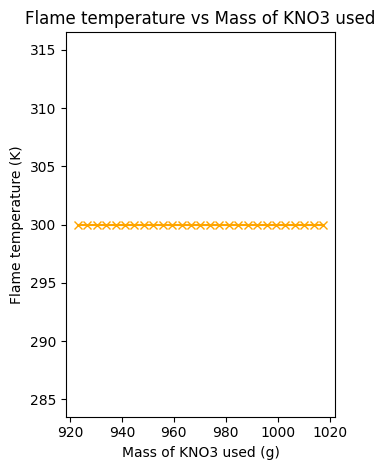

In [16]:

plt.subplot(1, 2, 2)
plt.plot(df.iloc[:, 2], chamber_temps, marker='x', color='orange')
plt.xlabel('Mass of KNO3 used (g)')
plt.ylabel('Flame temperature (K)')
plt.title('Flame temperature vs Mass of KNO3 used')

plt.tight_layout()
plt.show()

And finally, the $C^*$ vs mass of $KNO_3$ used:

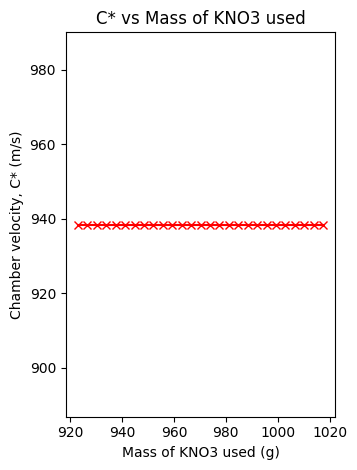

In [18]:
plt.subplot(1, 2, 2)
plt.plot(df.iloc[:, 2], c_stars, marker='x', color='red')
plt.xlabel('Mass of KNO3 used (g)')
plt.ylabel('Chamber velocity, C* (m/s)')
plt.title('C* vs Mass of KNO3 used')

plt.tight_layout()
plt.show()

## What we can learn from this data

We'll find that with more mass of $KNO_3$ used, do these critical factors i.e. $I_{sp}$, chamber temperature and $C^*$ increase. In reality, KNSB grains made with such concentrations of $KNO_3$ are harder to process and for the motor casing to handle.

We'll also find that with less mass of $KNO_3$ used, the motor is cooler but less energetic. We can see that at $65\%:35\%$ i.e. when mass of $KNO_3$ used is $944.84g$, we have the "[sweet spot](https://tenor.com/blpXi.gif)".

It's also worth mentioning that when too much oxidizer is used, the KNSB grain becomes brittle and sensitive to moisture while when too much fuel is used, incomplete combustion and lower $I_{sp}$ is noted. ([Nakka, 2025](https://www.nakka-rocketry.net/sorb.html))

## In conclusion...

We justified the optimal KNSB ratio i.e. $65\%:35\%$, as it provides a high specific impulse with efficient combustion, *indicated by $I_{sp}$ and $C^*$*, while maintaining safe thermal characteristics and physical integrity. It is a well-characterized formulation that makes it a reliable and practical choice for our SRM.

## References

1. R. Nakka, "KNSB Propellant," *Richard Nakka's Experimental Rocketry Web Site*, 2025. [Online]. Available: https://www.nakka-rocketry.net/sorb.html

2. J. Bonnie, J. Zehe, and S. Gordon, *NASA Glenn Coefficients for Calculating Thermodynamic Properties of Individual Species*, NASA/TP—2002-211556, Glenn Research Center, Cleveland, 2002.
3. T. McReary, *EXPERIMENTAL COMPOSITE PROPELLANT: An Introduction To Properties And Preparation OF Composite Propellants: Design, Construction, Testing, and Characteristics Of Small Rocket Motors.*, 1st Edition, 2020.